<a href="https://colab.research.google.com/github/Chan99999/Section2_Project/blob/main/S2_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 540 kB 15.0 MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582639 sha256=e07de2927ff851317d9774d64cf687cc9619cbb14cb670a47bd8636c1fdaf42e
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


In [2]:
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split
#---------------------------------------------

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier


#---------------------------------------------
from sklearn import tree
from IPython.display import Image
from sklearn.metrics import accuracy_score

#---------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns # heatmap
import mglearn
import joblib

import pydotplus
import os
import pandas as pd
import numpy as np
import pickle
import numpy as np
import json
import re 
import time
import ast
from pandas.io.json import json_normalize
import json

In [3]:
# 데이터 업로드
from google.colab import files
uploaded = files.upload()

Saving match_loser_data_version1.csv to match_loser_data_version1.csv
Saving match_winner_data_version1.csv to match_winner_data_version1.csv
Saving new_match_chall+grand.csv to new_match_chall+grand.csv


In [4]:
win_data = pd.read_csv('match_winner_data_version1.csv')
lose_data = pd.read_csv('match_loser_data_version1.csv')
plus_data = pd.read_csv('new_match_chall+grand.csv')

In [5]:
print(win_data['win'].unique())
print(lose_data['win'].unique())

# Nan값 제거
lose_data = lose_data.dropna(axis=0)

['Win']
['Fail' nan]


In [6]:
win_data.sample(5)
lose_data.sample(5)

# 10만 게임중 서로다른 게임끼리 학습을 위해 분리
win_data = win_data[:50415]
lose_data = lose_data[50414:]

In [7]:
# 데이터 결합
win_data.sample(5)
lose_data.sample(5)

lol_data = pd.merge(win_data,lose_data, how="outer")
lol_data.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [8]:
# 데이터 셔플
lol_data_shuffle = lol_data.sample(frac=1).reset_index(drop=True)

# 데이터 전처리 불필요한 열 제거
lol_data_shuffle = lol_data_shuffle.drop(['bans','gameId'], axis = 1)

# 추가 데이터 전처리 불필요한 열 제거
plus_data = plus_data.drop(['gameId'],axis = 1)

In [9]:
# 데이터 전처리과정
lol_data_shuffle = lol_data_shuffle.drop(['teamId','dominionVictoryScore','vilemawKills'],axis = 1)
plus_data = plus_data.drop(['teamId'],axis = 1)

lol_data_shuffle = lol_data_shuffle.replace('Win',1)
lol_data_shuffle = lol_data_shuffle.replace('Fail',0)
plus_data = plus_data.replace('Win',1)
plus_data = plus_data.replace('Fail',0)

In [10]:
# 추가 데이터(약 7만개) + 기존 데이터(약 11만개)
add_data = pd.concat([lol_data_shuffle,plus_data], ignore_index = True)

In [11]:
## 데이터 통계

# 첫번째 킬한 상황
win_kill_data = add_data[add_data['win']==1.0]['firstBlood']
win_firstblood = win_kill_data.value_counts(normalize=True)

lose_kill_data = add_data[add_data['win']==0.0]['firstBlood']
# print(data2.value_counts(normalize=True))
lose_firstblood = lose_kill_data.value_counts(normalize=True)

# print('Game win : \n',win_firstblood)
# print('Game lose : \n',lose_firstblood)


# 첫번째 타워 먹은 상황
win_tower_data = add_data[add_data['win']==1.0]['firstTower']
win_firsttower = win_tower_data.value_counts(normalize=True)

lose_tower_data = add_data[add_data['win']==0.0]['firstTower']
lose_firsttower = lose_tower_data.value_counts(normalize=True)


# 첫번째 억제기 먹은 상황
win_inhib_data = add_data[add_data['win']==1.0]['firstInhibitor']
win_Inhibit = win_inhib_data.value_counts(normalize=True)

lose_inhib_data = add_data[add_data['win']==0.0]['firstInhibitor']
lose_Inhibit = lose_inhib_data.value_counts(normalize=True)
# print(win_Inhibit)
# print(lose_Inhibit)
# 첫번째 바론 먹은 상황
win_baron_data = add_data[add_data['win']==1.0]['firstBaron']
win_firstbaron = win_baron_data.value_counts(normalize=True)

lose_baron_data = add_data[add_data['win']==0.0]['firstBaron']
lose_firstbaron = lose_baron_data.value_counts(normalize=True)


# 첫번째 용 먹은 상황
win_dragon_data = add_data[add_data['win']==1.0]['firstDragon']
win_firstdragon = win_dragon_data.value_counts(normalize=True)

lose_dragon_data = add_data[add_data['win']==0.0]['firstDragon']
lose_firstdragon = lose_dragon_data.value_counts(normalize=True)


# 첫번째 전령 먹은 상황
win_riftherald_data = add_data[add_data['win']==1.0]['firstRiftHerald']
win_firstriftherald = win_riftherald_data.value_counts(normalize=True)

lose_riftherald_data = add_data[add_data['win']==0.0]['firstRiftHerald']
lose_firstriftherald = lose_riftherald_data.value_counts(normalize=True)


print("0은 오브젝트를 못먹은 경우, 1은 오브젝트를 먹은 경우")
data_weight = pd.DataFrame({'WinGame_Firstkill':[win_firstblood[0],win_firstblood[1]],
                           'LoseGame_Firstkill':[lose_firstblood[0],lose_firstblood[1]],
                           
                            'WinGame_firsttower':[win_firsttower[0],win_firsttower[1]],
                           'LoseGame_firsttower':[lose_firsttower[0],lose_firsttower[1]],
                         
                            'WinGame_firstInhibit':[win_Inhibit[0],win_Inhibit[1]],
                           'LoseGame_firstInhibit':[lose_Inhibit[0],lose_Inhibit[1]],
                          
                            'WinGame_firstbaron':[win_firstbaron[0],win_firstbaron[1]],
                           'LoseGame_firstbaron':[lose_firstbaron[0],lose_firstbaron[1]],
                            
                           'WinGame_firstdragon':[win_firstdragon[0],win_firstdragon[1]],
                           'LoseGame_firstdragon':[lose_firstdragon[0],lose_firstdragon[1]],
                         
                            'WinGame_firstriftherald':[win_firstriftherald[0],win_firstriftherald[1]],
                           'LoseGame_firstriftherald':[lose_firstriftherald[0],lose_firstriftherald[1]],
                           })

print(data_weight)
a = np.array(data_weight)
print(a[0])
print(a[1])

0은 오브젝트를 못먹은 경우, 1은 오브젝트를 먹은 경우
   WinGame_Firstkill  LoseGame_Firstkill  WinGame_firsttower  \
0           0.396899            0.601059            0.260374   
1           0.603101            0.398941            0.739626   

   LoseGame_firsttower  WinGame_firstInhibit  LoseGame_firstInhibit  \
0             0.732654               0.31526               0.940678   
1             0.267346               0.68474               0.059322   

   WinGame_firstbaron  LoseGame_firstbaron  WinGame_firstdragon  \
0            0.579118             0.914322             0.448931   
1            0.420882             0.085678             0.551069   

   LoseGame_firstdragon  WinGame_firstriftherald  LoseGame_firstriftherald  
0              0.712084                 0.404461                  0.679182  
1              0.287916                 0.595539                  0.320818  
[0.396899   0.60105944 0.26037431 0.73265381 0.31526004 0.94067778
 0.57911821 0.914322   0.44893106 0.71208371 0.40446125 0.679

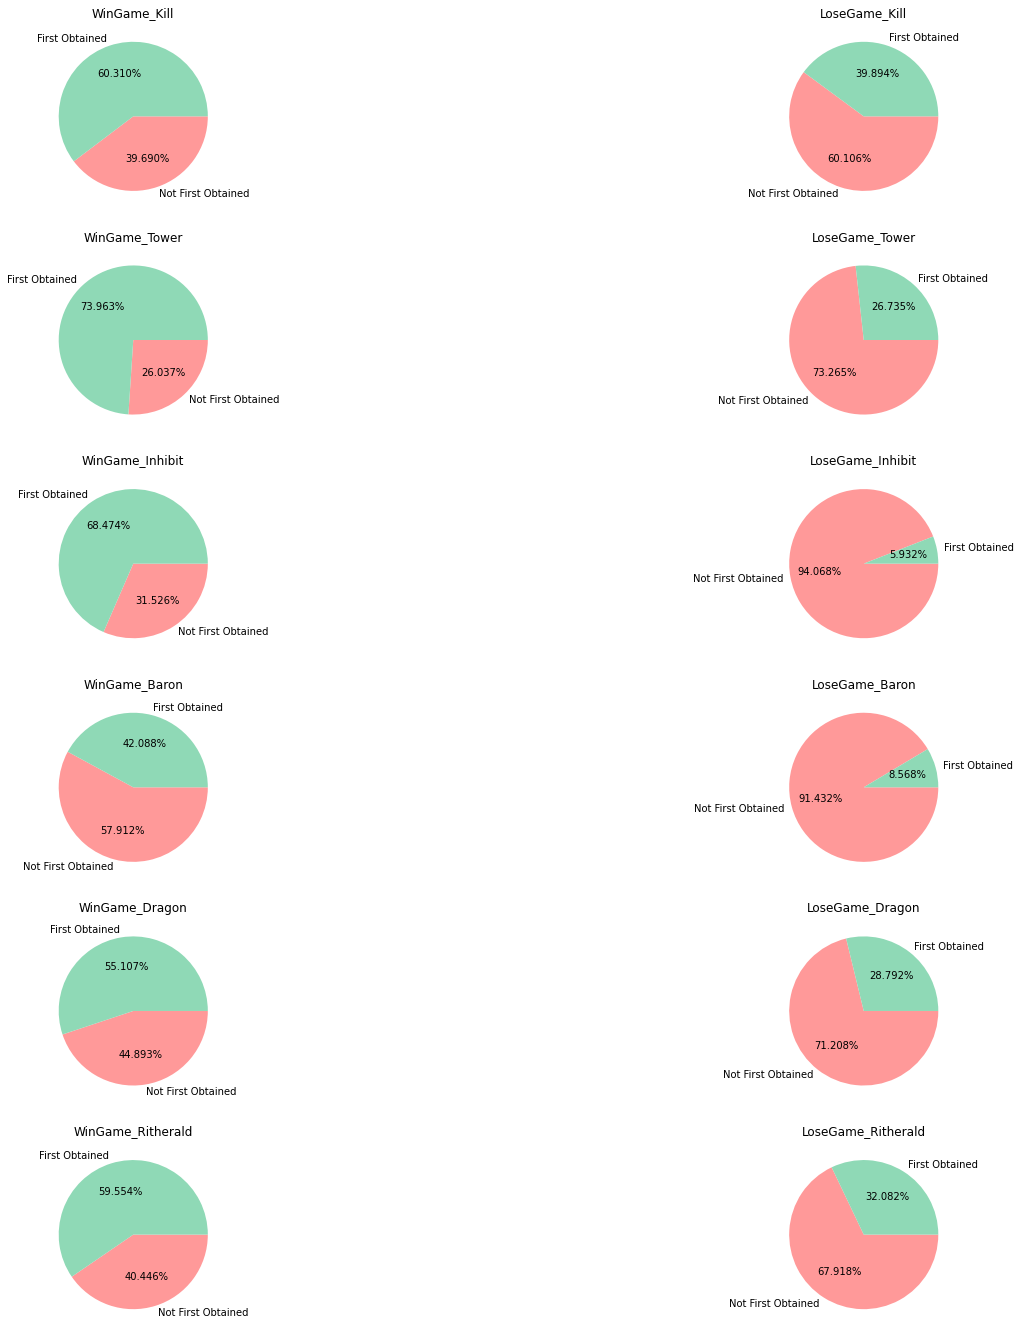

In [12]:
# 데이터 시각화

# 총 17만개의 게임경기 데이터
colors = ['#FF9999', '#8fd9b6']
fig, axes = plt.subplots(6,2,figsize=(24,24))

num = 0
for i in range(6):
    for j in range(2):
        axes[i][j].pie((a[0][num],a[1][num]),labels=['Not First Obtained','First Obtained'],autopct='%.3f%%', startangle=360, counterclock=False, colors = colors)
        num += 1

axes[0][0].set_title("WinGame_Kill")
axes[0][1].set_title("LoseGame_Kill")        
axes[1][0].set_title("WinGame_Tower")
axes[1][1].set_title("LoseGame_Tower")    
axes[2][0].set_title("WinGame_Inhibit")
axes[2][1].set_title("LoseGame_Inhibit")    
axes[3][0].set_title("WinGame_Baron")
axes[3][1].set_title("LoseGame_Baron")  
axes[4][0].set_title("WinGame_Dragon")
axes[4][1].set_title("LoseGame_Dragon")    
axes[5][0].set_title("WinGame_Ritherald")
axes[5][1].set_title("LoseGame_Ritherald")    

plt.show()

정확도 :  0.8719571015150656


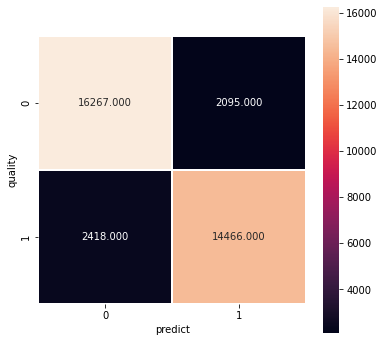

5 폴드세트 0.8722606224131567
6 폴드세트 0.8726464880324131
7 폴드세트 0.8727316053051491
8 폴드세트 0.8724138360527993
9 폴드세트 0.8729131820549836
10 폴드세트 0.8734352518797579
11 폴드세트 0.8729301920442901
12 폴드세트 0.8729018580345688
13 폴드세트 0.8731685631052701
14 폴드세트 0.8725557292698625


In [13]:
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold

add_data = add_data.replace(True,1)
add_data = add_data.replace(False,0)

train_x = np.array(pd.DataFrame(add_data, columns=['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald',
                                                          'towerKills','inhibitorKills','baronKills','dragonKills','riftHeraldKills']))  

train_y = np.array(pd.DataFrame(add_data, columns=['win'])) 

train_x = train_x.astype(np.int64)
train_y = train_y.astype(np.int64)


X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.20, random_state=36)

dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(X_train, Y_train)
df_prediction = dt_clf.predict(X_test)

print("정확도 : ", accuracy_score(Y_test,df_prediction))

conf_mat = confusion_matrix(Y_test,df_prediction)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("quality")
plt.xlabel("predict")
plt.show()


for i in range(5,15):
    kf = StratifiedKFold(n_splits=i, shuffle = True)
    score = cross_val_score(dt_clf, train_x, train_y, cv = kf, scoring="accuracy")
    print(i,"폴드세트",score.mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was

0.8789622476083165
정확도 :  0.8795040571979799


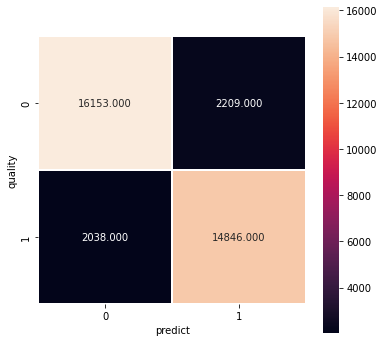

In [14]:
forest=RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_leaf = 3, min_samples_split = 10)

forest.fit(X_train, Y_train)

forest_prediction = forest.predict(X_test)


kf = StratifiedKFold(n_splits=5, shuffle = True)
score = cross_val_score(forest, train_x, train_y, cv = kf, scoring="accuracy")
print(score.mean())

print("정확도 : ", accuracy_score(Y_test,forest_prediction))

conf_mat = confusion_matrix(Y_test,forest_prediction)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("quality")
plt.xlabel("predict")
plt.show()

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OrdinalEncoder(),  
    RandomForestClassifier( class_weight= 'balanced')
)

# 최적값을 구하고 싶은 파라미터를 정리 
dists = {
    'randomforestclassifier__max_depth' : [3,5,10,15],
    'randomforestclassifier__max_features' : [3,5,10],
    'randomforestclassifier__n_estimators' : [80, 100, 150, 200]
}

# RandomizedSearchCV 작성
clf1= RandomizedSearchCV(
    pipe,
    param_distributions=dists, # 파라미터 입력
    n_iter = 500,   # random search 탐색 횟수
    cv = 5,        # cv 검증을 위한 분할 검증 횟수
    scoring='accuracy',  # 오차 평가방법
    verbose=1,     # 진행상황
    random_state = 2
  )

clf1.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 48 is smaller than n_iter=500. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these param

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced'))]),
                   n_iter=500,
                   param_distributions={'randomforestclassifier__max_depth': [3,
                                                                              5,
                                                                              10,
                                                                              15],
                                        'randomforestclassifier__max_features': [3,
                                                                                 5,
                                                                                 10],
                                        'randomforestclassifier_

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix
print('최적 하이퍼파라미터: ', clf1.best_params_)
y_test_pred = clf1.predict(X_test)
print('검증 정확도:', clf1.best_score_)
print('F1:',f1_score(Y_test, y_test_pred))

최적 하이퍼파라미터:  {'randomforestclassifier__n_estimators': 80, 'randomforestclassifier__max_features': 3, 'randomforestclassifier__max_depth': 3}
검증 정확도: nan
F1: 0.8533541341653667


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 세트 정확도: 0.858
테스트 세트 정확도: 0.860
정확도 :  0.8596720195199455


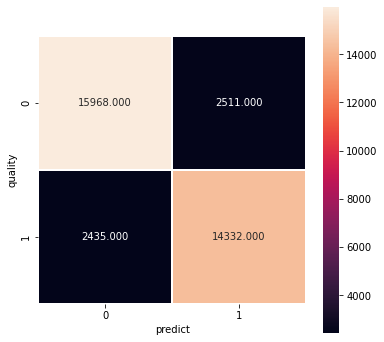

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.20, random_state=48)

gbrt = GradientBoostingClassifier(random_state=48,learning_rate = 0.01)
gbrt.fit(X_train, Y_train)

gbrt_prediction = gbrt.predict(X_test)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train, Y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test, Y_test)))

print("정확도 : ", accuracy_score(Y_test,gbrt_prediction))

conf_mat = confusion_matrix(Y_test,gbrt_prediction)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("quality")
plt.xlabel("predict")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


정확도 :  0.8707654769335528
[[15939  2540]
 [ 2015 14752]]


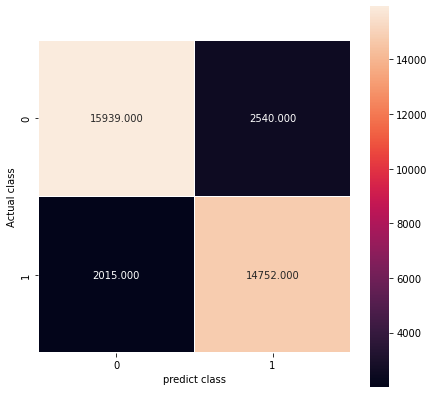

In [32]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.20, random_state=48)

#xgb = XGBClassifier(n_estimators = 300, learning_rate = 1, max_depth = 4)
xgb = XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=1, max_delta_step=0,
                                     max_depth=4, min_child_weight=1, monotone_constraints='()',
                                     n_estimators=300, n_jobs=48,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
                                     verbosity=None)

xgb = XGBClassifier()
evals = [(X_test,Y_test)]

#xgb.fit(X_train, Y_train, early_stopping_rounds = 100, eval_metric='logloss', eval_set = evals, verbose=True)
xgb.fit(X_train, Y_train)

y_pred = xgb.predict(X_test)

accuracy_score(Y_test,y_pred)
print("정확도 : ",accuracy_score(Y_test,y_pred))

conf_mat = confusion_matrix(Y_test,y_pred)
print(confusion_matrix(Y_test,y_pred))

plt.figure(figsize=(7,7))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("Actual class")
plt.xlabel("predict class")
plt.show()

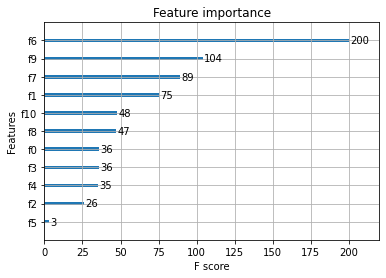

In [33]:
from xgboost import XGBClassifier, plot_importance

fig, ax = plt.subplots()
plot_importance(xgb, ax = ax)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's binary_logloss: 0.355905	valid_0's binary_logloss: 0.355905
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's binary_logloss: 0.320051	valid_0's binary_logloss: 0.320051
[3]	valid_0's binary_logloss: 0.310181	valid_0's binary_logloss: 0.310181
[4]	valid_0's binary_logloss: 0.306641	valid_0's binary_logloss: 0.306641
[5]	valid_0's binary_logloss: 0.304147	valid_0's binary_logloss: 0.304147
[6]	valid_0's binary_logloss: 0.301722	valid_0's binary_logloss: 0.301722
[7]	valid_0's binary_logloss: 0.300434	valid_0's binary_logloss: 0.300434
[8]	valid_0's binary_logloss: 0.299045	valid_0's binary_logloss: 0.299045
[9]	valid_0's binary_logloss: 0.298081	valid_0's binary_logloss: 0.298081
[10]	valid_0's binary_logloss: 0.297495	valid_0's binary_logloss: 0.297495
[11]	valid_0's binary_logloss: 0.296502	valid_0's binary_logloss: 0.296502
[12]	valid_0's binary_logloss: 0.295241	valid_0's binary_logloss: 0.295241
[13]	valid_0's binary_logloss: 0.295306	valid_0

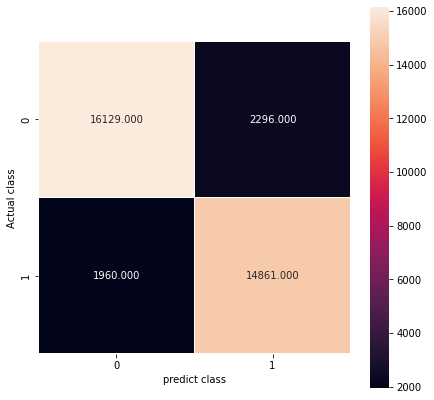

In [34]:
from lightgbm import LGBMClassifier, plot_importance

X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.20, random_state=42)

lgb = LGBMClassifier(n_estimators = 300, learning_rate = 1, max_depth = 4)
evals = [(X_test,Y_test)]
lgb.fit(X_train, Y_train, early_stopping_rounds = 50, eval_metric='logloss', eval_set = evals, verbose=True)

y_pred = lgb.predict(X_test)

accuracy_score(Y_test,y_pred)
print("정확도 : ",accuracy_score(Y_test,y_pred))

conf_mat = confusion_matrix(Y_test,y_pred)
print(confusion_matrix(Y_test,y_pred))

plt.figure(figsize=(7,7))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("Actual class")
plt.xlabel("predict class")
plt.show();

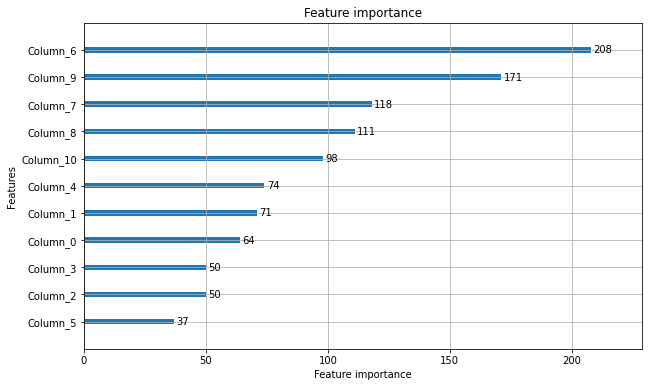

In [35]:
fig, ax = plt.subplots(figsize = (10,6))
plot_importance(lgb, ax = ax)

In [36]:
# 실제 내가 실행한 게임을 대입해 예측
# 킬 타워 억제기 바론 용 전령 타워수 억제기수 바론수 용수 전령수

game1 = np.array([[0,1,0,0,1,1,4,0,0,1,1]]) # 승리예측 성공
game2 = np.array([[0,0,0,1,1,1,4,0,1,2,2]]) # 패배예측 실패 
game3 = np.array([[0,0,0,0,1,0,1,0,0,1,0]]) # 패배예측 성공
game4 = np.array([[0,1,0,0,1,0,7,0,0,3,1]]) # 승리예측 성공
game5 = np.array([[1,0,0,0,0,0,6,1,0,3,0]]) # 승리예측 성공


game1_result = forest.predict(game1)
game2_result = forest.predict(game2)
game3_result = forest.predict(game3)
game4_result = forest.predict(game4)
game5_result = forest.predict(game5)

print("1=승리, 0=패배: ",game1_result)
print("1=승리, 0=패배: ",game2_result)
print("1=승리, 0=패배: ",game3_result)
print("1=승리, 0=패배: ",game4_result)
print("1=승리, 0=패배: ",game5_result)

1=승리, 0=패배:  [1]
1=승리, 0=패배:  [1]
1=승리, 0=패배:  [0]
1=승리, 0=패배:  [1]
1=승리, 0=패배:  [1]
